In [1]:
import numpy as np
import time
import math
import modules as md
#import nbodysolver as nbs
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


#------------------------------------------------------------------------------------------
#Units and conversions:
#------------------------------------------------------------------------------------------
#code units: Rsun, Msun, G=1, ...
c_SI       = 299792458.0        #m/s
M_sun_SI   = 1.989*(10.**30.)   #kg
R_sun_SI   = 695800000.         #m
R_bull_SI = 1000 #m 
AU_SI      = 149597871000.      #m 
G_new_SI   = 6.67*(10.**(-11.)) #m**3 kg**(-1) s**(-2)
AU_U       = AU_SI/R_sun_SI                             #from dist AU to code units (U)
kmsec_U    = 1000./np.sqrt(G_new_SI*M_sun_SI/R_bull_SI)  #from vel km/sec to code units (U)
time_U     = 1/np.sqrt(G_new_SI*M_sun_SI/R_bull_SI**3) #from CU to second np.sqrt((R_bull_SI)/(G_new_SI*M_sun_SI)) #from code units(U) to time sec
#Rsch_1Msun_unitRsun = ((2.*G_new_SI*(1.*M_sun_SI))/(c_SI**2.))/R_sun_SI
c_CU = c_SI/1000*kmsec_U

# Newtonian

In [2]:
#Acceleration

def acc(r,m): #r position, m mass
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = (rrel**2).sum()**(1./2) 
                a[i] += -(rrel)*m[j]/(rn**3.0) #Acceleration at each time step 
    return a # return acceleration


def Jerk(r,v,m): #position, velocity, mass
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = (rrel**2).sum()**(1./2) # dot product
                vn = (vrel**2).sum()**(1./2)
                rvd = ((rrel)*(vrel)).sum()
                Je[i] += - m[j]*((vrel)/rn**3.0 - 3.*(rvd*rrel/(rn**5.0))) 
    return Je;

# Spin

Evolution of $r$ and $v$ in the equations of motion

In [3]:
def accspin(r,m,ns,S):#r,m,S,ns #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = rrel/rn
                Sn = ((S[i]*S[i]).sum())**(1./2)
                a[i] += -(3./2)*ns[i]*(m[j]*Sn**2/m[i])*(runi)/(rn**4.0) #Acceleration at each time step
                
    return a # return acceleration

def Jerkspin(r,v,m, ns,S):#r,v,m,S,ns #r position, v velocity, m mass, m mass of the star, ne
    Je = np.zeros((len(r),3)) #Define the Jerk
    Je1 = np.zeros((len(r),3))
    Je2 = np.zeros((len(r),3))
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = (r[i]-r[j])
                vrel = (v[i]-v[j])
                rn = ((rrel**2).sum())**(1./2) # dot product
                Sn = ((S[i]*S[i]).sum())**(1./2)
                #Je1[i] += - (3./2)*ns[i]*((m[j])/m[i])*(2*((S*b).sum())*rrel/r**5 ) #Still need to define b 
                Je2[i] += - (3./2)*ns[i]*((m[j])/m[i])*(Sn**2)*(vrel/rn**5.0 - 5.*((vrel*rrel).sum())*(rrel)/(rn**7.0))               
                Je[i] += Je2[i] #Je1[i] + Je2[i] 
    return Je;


def HermiteUpdatespindt(dt, r, v, m, ns, S): # m mass of the star
    
    aN = acc(r, m) 
    aS = accspin(r, m, ns, S)
    a = aN + aS           # current acceleration
    aNdot = Jerk(r,v,m)
    aSdot = Jerkspin(r, v, m, ns, S)
    adot = aNdot + aSdot # current jerks
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aSp = accspin(rp, m, ns, S)
    ap = aNp + aSp         # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aSdotp = Jerkspin(rp, vp, m, ns, S)
    adotp = aNdotp + aSdotp  # predicted jerks 
    
    dtp = dt
    
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + dt/2*(adotp + adot)
    aNc = aN + dt/2*(aNdotp + aNdot)
    
    Sc = S
 
    return rc,vc,Sc, ac, aNc,dtp #,ac,aNc,dtp
'''
def Hermite4thspindt(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))
    S_res = np.zeros((2,3,nsteps)) # 2 because of two bodies


    aN_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adotN_res = np.zeros((2,3,nsteps))

    a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    S_res[:,:,0] = bina.S.copy()

    nspinv = np.array([pri.nspin, sec.nspin])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i],S_res[:,:,i], a_res[:,:,i],aN_res[:,:,i], dtp[i]) = HermiteUpdatespindt(Dt, r_res[:,:,i-1], v_res[:,:,i-1],  m, nspinv, S_res[:,:,i-1])
        time[i] = time[i-1] + Dt#
        if time[i] >= timelimit:
            break
            
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    a_res = a_res[:,:,:i]
    #adot_res = adot_res[:,:,:i]
    aN_res = aN_res[:,:,:i]
    #adotN_res = adotN_res[:,:,:i]
    S_res = S_res[:,:,i]
    dtp = dtp[:i]
    time = time[:i]
        
    return r_res, v_res, a_res, aN_res, S_res, dtp, time
'''

'\ndef Hermite4thspindt(pri,sec, bina, nsteps, Dt):\n    \n    N=2\n    m = np.ones(N)#/N #Remove the N if not necessary\n    m[0]=pri.mass\n    m[1]=sec.mass\n    \n    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies\n    v_res = np.zeros((2,3,nsteps))\n    S_res = np.zeros((2,3,nsteps)) # 2 because of two bodies\n\n\n    aN_res = np.zeros((2,3,nsteps)) # 2 because of two bodies\n    #adotN_res = np.zeros((2,3,nsteps))\n\n    a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies\n    #adot_res = np.zeros((2,3,nsteps))\n\n    \n    time = np.zeros(nsteps)\n    r_res[:,:,0] = bina.r.copy()\n    v_res[:,:,0] = bina.v.copy()\n    S_res[:,:,0] = bina.S.copy()\n\n    nspinv = np.array([pri.nspin, sec.nspin])\n    \n    dtp = np.zeros(nsteps)\n    dtp[0] = Dt\n    \n    for i in range(1,nsteps):\n        (r_res[:,:,i],v_res[:,:,i],S_res[:,:,i], a_res[:,:,i],aN_res[:,:,i], dtp[i]) = HermiteUpdatespindt(Dt, r_res[:,:,i-1], v_res[:,:,i-1],  m, nspinv, S_res[:,:,i-1])\n        time[i

In [4]:
def Hermite4thspindt(pri,sec, bina, nsteps,Dt):

    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))
    S_res = np.zeros((2,3,nsteps)) # 2 because of two bodies


    aN_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies
    #adotN_res = np.zeros((2,3,nsteps))

    a_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies
    #adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    S_res[:,:,0] = bina.S.copy()
    
    nspinv = np.array([pri.nspin, sec.nspin])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i], v_res[:,:,i], S_res[:,:,i], a_res[:,:,i-1],aN_res[:,:,i-1], dtp[i]) = HermiteUpdatespindt(Dt, r_res[:,:,i-1], v_res[:,:,i-1],  m, nspinv, S_res[:,:,i-1])
        #
        time[i] = time[i-1] + Dt#
        if time[i] >= timelimit:
            break
    
    n = 0
    r_res = r_res[:,:,:i+1]
    v_res = v_res[:,:,:i+1]
    a_res = a_res[:,:,:i]
    S_res = S_res[:,:,:i+1]
    dtp = dtp[:i+1]
    time = time[:i+1]

    return r_res, v_res, S_res, a_res, aN_res, time

In [5]:
'''#Define ns
ns = md.Particle("NS",1.2,8.89,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius
#Define bh
bh3 = md.Particle("BH",5,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius


#Define binary
bh3ns10rt = md.Binary(bh3, ns, 4*ns.radi, 0)

rt = 10

bh3nsco = md.Binary(bh3, ns, rt*ns.radi, 0) ##primary, secondary, orbital distance (Rsun), eccentricity
'''

'#Define ns\nns = md.Particle("NS",1.2,8.89,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius\n#Define bh\nbh3 = md.Particle("BH",5,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius\n\n\n#Define binary\nbh3ns10rt = md.Binary(bh3, ns, 4*ns.radi, 0)\n\nrt = 10\n\nbh3nsco = md.Binary(bh3, ns, rt*ns.radi, 0) ##primary, secondary, orbital distance (Rsun), eccentricity\n'

In [6]:
ns = md.Particle("NS",1.2,8.89,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius
bh3 = md.Particle("BH",5,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius


Sd = np.array([0.1,0.3])
omega = (Sd*(ns.mass**2))/(ns.inertiam*c_CU)
#nsspinarr = np.array([0,0,ns.sdis/3])
nsspinarr = np.array([0,0,omega[1]])

nsspin = md.Particle("NS",1.2,8.89, nsspinarr)

bh3nsspin = md.Binary(bh3,nsspin, 8*nsspin.radi,0)

In [7]:
nsspin.spin

array([0.        , 0.        , 0.01585166])

# Measure the coefficient for spin effects 

In [8]:
tl = 1*bh3nsspin.periodct #Time of the simulation in [cpde units]
timelimit = tl #
dt = 0.1 # 0.0001 working better 
Nsteps = int(tl/dt)#Number of ti

r,v,S,a,aN,time = Hermite4thspindt(bh3,nsspin, bh3nsspin, Nsteps, dt)

print(S)

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.01585166 0.01585166 0.01585166 ... 0.01585166 0.01585166 0.01585166]]]


In [9]:
print(r[0].T)

[[1.37651613e+01 0.00000000e+00 0.00000000e+00]
 [1.37651601e+01 5.71464840e-03 0.00000000e+00]
 [1.37651565e+01 1.14292958e-02 0.00000000e+00]
 ...
 [1.37646666e+01 1.60130736e-01 0.00000000e+00]
 [1.37646239e+01 1.65845225e-01 0.00000000e+00]
 [1.37645789e+01 1.71559696e-01 0.00000000e+00]]


In [10]:
print(len(r[0].T))

15134


In [75]:
print(len(r[0].T))

15134


No handles with labels found to put in legend.


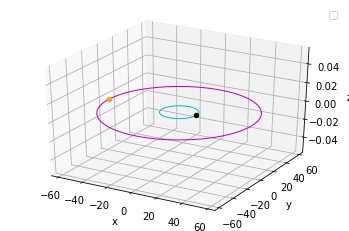

In [76]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(r[0][0], r[0][1], r[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(r[1][0], r[1][1], r[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(r[0][0][-1], r[0][1][-1], r[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(r[1][0][-1], r[1][1][-1], r[1][2][-1], '0', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


#plt.savefig('ne-circular2rt-5orbits.eps',bbox_inches='tight')#, dpi=300

plt.show()

In [77]:
aratio = np.zeros_like(aN[1].T)
for i in range(len(aN[1].T)-1):
    aratio[i+1][0] = (a[1].T[i+1][0])/(aN[1].T[i+1][0])
    aratio[i+1][1] = (a[1].T[i+1][1])/(aN[1].T[i+1][1])
    #print(aratio[i][1])
    
#define relative position
relpos = r[1].T - r[0].T 
#define relative velocity
relvel = v[1].T - v[0].T

normrelpos = np.zeros([len(relpos), 1]) 
normrelvel = np.zeros([len(relvel), 1]) 
normS = np.zeros([len(relvel), 1]) 

for i in range(len(normrelpos)):
    normrelpos[i] = np.sqrt(relpos[i][0]**2 + relpos[i][1]**2 + relpos[i][2]**2)
    normrelvel[i] = np.sqrt(relvel[i][0]**2 + relvel[i][1]**2 + relvel[i][2]**2)
    normS[i] = np.linalg.norm(S[1].T[i])
    
print(len(normrelpos.T[0]))
print(min(normrelpos))
print(max(normrelpos))

15134
[71.0208615]
[71.12]


In [78]:
print(np.shape(aratio))
print(np.shape(normrelpos))
print(np.shape(normS))

(15133, 3)
(15134, 1)
(15134, 1)


In [79]:
n_exco = (normrelpos.T[0][1:]**2)*(2./3)*(1.*ns.mass/normS.T[0][1:]**2)*(aratio.T[0][:] - 1) 
n_eyco = (normrelpos.T[0][1:]**2)*(2./3)*(1.*ns.mass/normS.T[0][1:]**2)*(aratio.T[1][:] - 1)

In [80]:
print(n_exco)

[-1.61036427e+07  1.39176566e+04  1.39176566e+04 ...  1.39176566e+04
  1.39176566e+04  1.39176566e+04]


In [81]:
print(np.shape(time))
print(np.shape(n_exco))

(15134,)
(15133,)


No handles with labels found to put in legend.


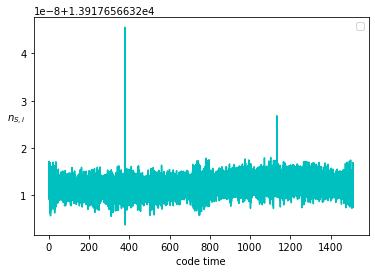

In [49]:
plt.plot(time[2:], n_exco[1:], 'c-', alpha = 1)
#plt.plot(timearrayN.T[0][2:], n_ey[1:], 'b-', label = r'$n_{Ey}$', alpha = 0.5)
#plt.plot(timearrayT[1:], posydif, 'b-', label = r'$\Delta y$', alpha = 0.8)

#plt.plot(timeave, dynstave.T[1], 'b-', label = r'$star$', alpha = 0.8)
#plt.plot(time[1:], n_e.T[2], 'g-', label = r'$n_{ez}$', alpha = 0.8)
#plt.xlim(0,30)
#plt.ylim(0.0955,0.09555)
plt.xlabel('code time')
plt.ylabel(r'$n_{S,i}$',rotation=0)

#plt.title(r'$n_{S,i}$ circular orbit')
plt.legend()
#plt.savefig('ne-evolution-circular-0.001-4rs-5orbits.eps', bbox_inches='tight')#, dpi=300

plt.show()

In [22]:
print(n_exco)

[-1.06407048e+03  9.19628428e-01  9.19628428e-01 ...  9.19628428e-01
  9.19628428e-01  9.19628428e-01]


In [104]:
print(n_exco)

[-1.06414080e+03  9.19689198e-01  9.19689198e-01 ...  9.19689198e-01
  9.19689198e-01  9.19689198e-01]


In [23]:
print(nsspin.nspin)

13917.65663191198


In [25]:
print(bh3.ndtide)

0


In [131]:
n_exco = (normrelpos.T[0][:-1]**2)*(2./3)*(1.*ns.mass/normS.T[0][:-1]**2)*(aratio.T[0][:] - 1) 
n_eyco = (normrelpos.T[0][:-1]**2)*(2./3)*(1.*ns.mass/normS.T[0][:-1]**2)*(aratio.T[1][:] - 1)

No handles with labels found to put in legend.


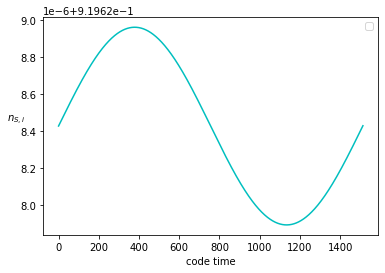

In [132]:
plt.plot(time[2:], n_exco[1:], 'c-', alpha = 1)
#plt.plot(timearrayN.T[0][2:], n_ey[1:], 'b-', label = r'$n_{Ey}$', alpha = 0.5)
#plt.plot(timearrayT[1:], posydif, 'b-', label = r'$\Delta y$', alpha = 0.8)

#plt.plot(timeave, dynstave.T[1], 'b-', label = r'$star$', alpha = 0.8)
#plt.plot(time[1:], n_e.T[2], 'g-', label = r'$n_{ez}$', alpha = 0.8)
#plt.xlim(0,30)
#plt.ylim(0.0955,0.09555)
plt.xlabel('code time')
plt.ylabel(r'$n_{S,i}$',rotation=0)

#plt.title(r'$n_{S,i}$ circular orbit')
plt.legend()
#plt.savefig('ne-evolution-circular-0.001-4rs-5orbits.eps', bbox_inches='tight')#, dpi=300

plt.show()

# Now we add the spin evolution

def accspin(r,m,ns,S):#r,m,S,ns #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = rrel/rn
                Sn = ((S[i]*S[i]).sum())**(1./2)
                a[i] += -(3./2)*ns[i]*(m[j]*Sn**2/m[i])*(runi)/(rn**4.0) #Acceleration at each time step
    return a

In [153]:

#Need to solve for each
def bccspin(r,v,m,ns,S,I): #r position, m mass, s spin, m mass of the star
    b = np.zeros((len(r),3)) #Create acceleration vector
    b1 = np.zeros((len(r),3))
    b2 = np.zeros((len(r),3))
    #bden = np.zeros((len(r),3))
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                if(ns[i] == 0.0):
                    b[i] = np.array([0,0,0])
                elif (ns[i] != 0):
                    rrel = r[i]-r[j]
                    rn = ((rrel**2).sum())*(1./2)
                    runi = 1.*rrel/rn
                    vrel = v[i] - v[j]
                    rdv = (rrel*vrel).sum()
                    Sn = ((S[i]*S[i]).sum())**(1./2)
                    acorr =  m[j]*ns[i]/rn**3
                    b1[i] += (1/(I[i]+acorr))*(3*ns[i]*m[j]*rdv*S[i])*(1/(rn**5.0))
                    #b2[i] += 
                    b[i] = b1[i] #b1[i] #+ b2[i]
    return b # return acceleration

In [154]:
(nsspin.nspin*bh3.mass)/(bh3nsspin.orbd**3)

0.1934465007070313

In [155]:
relr1 = bh3nsspin.r[1] - bh3nsspin.r[0]
velr1 = bh3nsspin.v[1] - bh3nsspin.v[0]
rdv1 = np.dot(relr1, velr1)


In [156]:
rdv1

0.0

In [172]:
def HermiteUpdatespinbdt(dt, r, v, m, ns, S,I): # m mass of the star
    
    aN = acc(r, m) 
    aS = accspin(r, m, ns, S)
    a = aN + aS           # current acceleration
    aNdot = Jerk(r,v,m)
    aSdot = Jerkspin(r, v, m, ns, S)
    adot = aNdot + aSdot # current jerks
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aSp = accspin(rp, m, ns, S)
    ap = aNp + aSp         # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aSdotp = Jerkspin(rp, vp, m, ns, S)
    adotp = aNdotp + aSdotp  # predicted jerks 
    
    dtp = dt
    
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + dt/2*(adotp + adot)
    aNc = aN + dt/2*(aNdotp + aNdot)
    
    #Spin
    
    b = bccspin(r,v,m,ns,S,I) #r,v,m,S,ns,I
    Sp = S + (dt*b) #+ ()*dt/2

    bp = bccspin(rp,vp,m,ns,Sp,I)
    Sc = S + (b + bp)*dt/2
    bc = b #+ ()*dt/2 Higher order terms
       
    
    #Sc = S
 
    return rc,vc,Sc, bc, ac, aNc, dtp

In [158]:
def Hermite4thspinbdt(pri,sec, bina, nsteps,Dt):

    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))
    S_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    b_res = np.zeros((2,3,nsteps-1))

    aN_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies
    #adotN_res = np.zeros((2,3,nsteps))

    a_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies
    #adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    S_res[:,:,0] = bina.S.copy()
    
    nspinv = np.array([pri.nspin, sec.nspin])
    Iv = np.array([pri.inertiam, sec.inertiam])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i], v_res[:,:,i], S_res[:,:,i], b_res[:,:,i-1] , a_res[:,:,i-1],aN_res[:,:,i-1], dtp[i]) = HermiteUpdatespinbdt(Dt, r_res[:,:,i-1], v_res[:,:,i-1],  m, nspinv, S_res[:,:,i-1], Iv)
        #
        time[i] = time[i-1] + Dt#
        if time[i] >= timelimit:
            break
            
    r_res = r_res[:,:,:i+1]
    v_res = v_res[:,:,:i+1]
    a_res = a_res[:,:,:i]
    aN_res = aN_res[:,:,:i]
    b_res = b_res[:,:,:i]
    S_res = S_res[:,:,:i+1]
    dtp = dtp[:i+1]
    time = time[:i+1]

    return r_res, v_res, S_res, b_res, a_res, aN_res, time

In [159]:
nsspinv = np.array([bh3.nspin, nsspin.nspin])

In [160]:
nsspinv[1]

13917.65663191198

In [161]:
tl = 1*bh3nsspin.periodct #Time of the simulation in [cpde units]
timelimit = tl #
dt = 0.1 # 0.0001 working better 
Nsteps = int(tl/dt)#Number of ti

r,v,S,b,a,aN,time = Hermite4thspinbdt(bh3,nsspin, bh3nsspin, Nsteps, dt)

print(b[1].T)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.86970210e-21]
 [ 0.00000000e+00  0.00000000e+00 -1.17394032e-20]
 ...
 [ 0.00000000e+00  0.00000000e+00 -3.47300800e-20]
 [ 0.00000000e+00  0.00000000e+00 -4.05997618e-20]
 [ 0.00000000e+00  0.00000000e+00 -4.64694368e-20]]


In [162]:
print(S[1])

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.01585166 0.01585166 0.01585166 ... 0.01585166 0.01585166 0.01585166]]


In [163]:
aratio = np.zeros_like(aN[1].T)
for i in range(len(aN[1].T)-1):
    aratio[i+1][0] = (a[1].T[i+1][0])/(aN[1].T[i+1][0])
    aratio[i+1][1] = (a[1].T[i+1][1])/(aN[1].T[i+1][1])
    #print(aratio[i][1])
    
#define relative position
relpos = r[1].T - r[0].T 
#define relative velocity
relvel = v[1].T - v[0].T

normrelpos = np.zeros([len(relpos), 1]) 
normrelvel = np.zeros([len(relvel), 1]) 
normS = np.zeros([len(relvel), 1]) 

for i in range(len(normrelpos)):
    normrelpos[i] = np.sqrt(relpos[i][0]**2 + relpos[i][1]**2 + relpos[i][2]**2)
    normrelvel[i] = np.sqrt(relvel[i][0]**2 + relvel[i][1]**2 + relvel[i][2]**2)
    normS[i] = np.linalg.norm(S[1].T[i])
    
print(len(normrelpos.T[0]))
print(min(normrelpos))
print(max(normrelpos))

15134
[71.0208615]
[71.12]


In [164]:
n_exco = (normrelpos.T[0][1:]**2)*(2./3)*(1.*ns.mass/normS.T[0][1:]**2)*(aratio.T[0][:] - 1) 
n_eyco = (normrelpos.T[0][1:]**2)*(2./3)*(1.*ns.mass/normS.T[0][1:]**2)*(aratio.T[1][:] - 1)

No handles with labels found to put in legend.


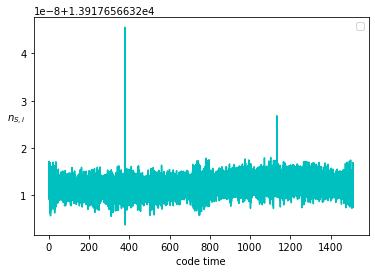

In [165]:
plt.plot(time[2:], n_exco[1:], 'c-', alpha = 1)
#plt.plot(timearrayN.T[0][2:], n_ey[1:], 'b-', label = r'$n_{Ey}$', alpha = 0.5)
#plt.plot(timearrayT[1:], posydif, 'b-', label = r'$\Delta y$', alpha = 0.8)

#plt.plot(timeave, dynstave.T[1], 'b-', label = r'$star$', alpha = 0.8)
#plt.plot(time[1:], n_e.T[2], 'g-', label = r'$n_{ez}$', alpha = 0.8)
#plt.xlim(0,30)
#plt.ylim(0.0955,0.09555)
plt.xlabel('code time')
plt.ylabel(r'$n_{S,i}$',rotation=0)

#plt.title(r'$n_{S,i}$ circular orbit')
plt.legend()
#plt.savefig('ne-evolution-circular-0.001-4rs-5orbits.eps', bbox_inches='tight')#, dpi=300

plt.show()

In [140]:
print(S[1][2][0]/S[1][2][-1])

1.0


In [452]:
print(b[0].T)
print(b[1].T)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.28976335e-11]
 [ 0.00000000e+00  0.00000000e+00 -4.57967702e-11]
 ...
 [ 0.00000000e+00  0.00000000e+00 -2.55534944e-10]
 [ 0.00000000e+00  0.00000000e+00 -2.78403387e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [431]:
Iv = np.array([bh3.inertiam, nsspin.inertiam])


In [61]:
#Need to generalize the code to take into account the fact that I am dividing the mass of the star
def accspin(r,m,S,ns): #r position, m mass, s spin, m mass of the star
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = ((rrel**2).sum())*(1./2)
                runi = 1.*rrel/rn
                Sn = np.linalg.norm(S) 
                a[i] += -(3*ns[i]*(m[j]/m[i])/(rn**4.0))*((runi*Sn**2/2))
                #a[i,:] += -(3*ns*(m[j]/ms)/(ra**4.0))*(S*(np.dot(runi,S)) + (runi*Sn**2/2) - (5*runi*(np.dot(runi, S)**2)))
    return a # return acceleration
'''
def bccspin(r,v,m,S,I,ns,eta):
    b = np.zeros((len(r),3))
    bden = np.zeros((len(r),3))
    bspin = np.zeros((len(r),3))
    bdiss = np.zeros((len(r),3))
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = ((rrel*rrel).sum())**(1./2)
                runi = rrel/rn
                rdv = (rrel*vrel).sum()
                rucv = np.cross(runi,vrel)
                bden[i] = 1./(I[i]*(rn**3) + m[j]*ns[i])
                bspin[i] = (3*m[j]*ns[i]*rdv*S[i]/(rn**5))
                bdiss[i] = 9.*eta[i]*(m[j]**2)*(rucv - rn*S[i] )/(rn**7)
                
                b[i] =  bden[i]*(bspin[i]*bdiss[i])
    return b
'''

def HermiteUpdatespindt(dt, r, v, m, S, I, ns, eta): # m mass of the star
    
    aN = acc(r, m) 
    aS = accspin(r, v, m, ns)
    a = aN + aS           # current acceleration
    aNdot = Jerk(r,v,m)
    aSdot = 0 #Jerkspin(r, v, a, m, ns)
    adot = aNdot + aSdot # current jerks
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aSp = accspin(rp, vp, m, ns)
    ap = aNp + aSp         # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aSdotp = 0#Jerkspin(rp, vp, ap, m, ns)
    adotp = aNdotp + aSdotp  # predicted jerks 
    
    dtp = dt
    
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + dt/2*(adotp+adot)
    #aNc = aN + dt/2*(aNdotp + aNdot)
    '''    
    #Spin
    
    b = bccspin(r,v,m,S,I,ns,eta)
    Sp = S + (dt*b) #+ ()*dt/2

    bp = bccspin(rp,vp,m,Sp,I,ns,eta)
    Sc = S + (b + bp)*dt/2
    bc = b #+ ()*dt/2 Higher order terms
    '''   
    
    So = S 
    
    return rc,vc, ac, So, dtp

def Hermite4thspindt(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v = np.zeros((2,3,nsteps))
    #aN = np.zeros((2,3,nsteps)) 
    a = np.zeros((2,3,nsteps))
    
    S = np.zeros((2,3,nsteps))
    b = np.zeros((2,3,nsteps))
    
    time = np.zeros(nsteps)
    r[:,:,0] = bina.r.copy()
    v[:,:,0] = bina.v.copy()
    S[:,:,0] = bina.S.copy()
    ntidev = np.array([pri.ntide, sec.ntide])
    etav = np.array([pri.eta, sec.eta])
    inertiav = np.array([pri.inertiam ,sec.inertiam])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r[:,:,i],v[:,:,i],a[:,:,i],S[:,:,i], dtp[i]) = HermiteUpdatespindt(Dt, r[:,:,i-1], v[:,:,i-1], m, S[:,:,i-1], inertiav, ntidev, etav)
        time[i] = time[i-1] + Dt#
        if time[i] >= timelimit:
            break
            
    r = r[:,:,:i]
    v = v[:,:,:i]
    a = a[:,:,:i]
    S = S[:,:,:i]
    dtp = dtp[:i]
    time = time[:i]
        
    return r, v, a, S, time


# Circular orbit

In [62]:
bh = md.Particle("BH",20,0,0.0)#stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius

bhspinarr = np.array([0,0,0.001])
bhspin = md.Particle("BH", 20,0,bhspinarr)
bhbhspin = md.Binary(bh,bhspin, 8*bh.radisch,0)

In [63]:
print(bhspin.radiplus)
print(bh.radisch)
print(bhspin.inertiam)

58.73903821222041
59.044466452570475
69005.49220193378


In [64]:
ns = md.Particle("NS",1.2,8.89,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius
bh3 = md.Particle("BH",5,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius

nsspinarr = np.array([0,0,ns.sdis/3])
nsspin = md.Particle("NS",1.2,8.89, nsspinarr)

bh3nsspin = md.Binary(bh3,nsspin, 8*nsspin.radi,0)

In [65]:
nsspin.inertiam

33.110723733380915

In [66]:
nsspin.spin

array([0.       , 0.       , 0.0137758])

In [67]:
tl = 1*bh3nsspin.periodct #Time of the simulation in [cpde units]
timelimit = tl #
dt = 0.1 # 0.0001 working better 
Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 

In [68]:
rbhns,vbhns, abhns, Sbhns, timebhns = Hermite4thspindt(bh3,nsspin, bh3nsspin,Nsteps,dt)

/home/irvin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [69]:
rbhns

array([[[ 13.76516129,          nan,          nan, ...,          nan,
                  nan,          nan],
        [  0.        ,          nan,          nan, ...,          nan,
                  nan,          nan],
        [  0.        ,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[-57.35483871,          nan,          nan, ...,          nan,
                  nan,          nan],
        [  0.        ,          nan,          nan, ...,          nan,
                  nan,          nan],
        [  0.        ,          nan,          nan, ...,          nan,
                  nan,          nan]]])

No handles with labels found to put in legend.


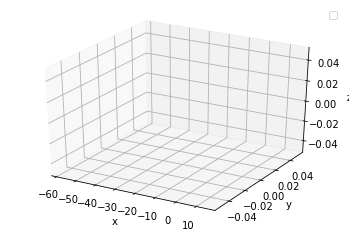

In [28]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rbhns[0][0], rbhns[0][1], rbhns[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(rbhns[1][0], rbhns[1][1], rbhns[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(rbhns[0][0][-1], rbhns[0][1][-1], rbhns[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(rbhns[1][0][-1], rbhns[1][1][-1], rbhns[1][2][-1], '0', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


#plt.savefig('ne-circular2rt-5orbits.eps',bbox_inches='tight')#, dpi=300

plt.show()

In [ ]:
rbhbh,vbhbh, abhbh, Sbhbh,  timebhbh = Hermite4thspindt(bh,bhspin, bhbh, Nsteps,dt)

In [ ]:
pri,sec, bina, nsteps, Dt

In [26]:
bhbh.r

array([[ 236.17786581,    0.        ,    0.        ],
       [-236.17786581,    0.        ,    0.        ]])

In [15]:
0.05/c_CU

0.06074766788351348

In [12]:
print(ns.nspin)
print(ns.sdis/3)
print(c_CU)

13917.65663191198
0.013775796760546896
0.82307686438066
